In [1]:
from IPython.display import display, HTML

display(HTML(data="""

<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

import numpy as np
import matplotlib.pyplot as plt
import time

import datetime
from math import *
import scipy.linalg
import scipy.integrate

%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 7) 

import os
import inspect
curr_path = "C:\\Users\\nicol\Documents\Work\ENS related stuff\M1\Stage M1\Code\Python"
path_data = curr_path+"\data"
os.chdir(path_data)


col = ['b', 'r', 'g', 'k', 'purple', 'p']
linestyles = ["-", "-.", ":", "--", (0, (10, 2, 1, 2, 1, 2))]
markers = ['o', 's', '^', 'v', 'h']

In [40]:
from formalism import init_gaussian_nD, update_param_1D_order2, _analyze_order, simu, _mk_spec_from_param, mk_spec

from post_processing import _plot_std_from_param, _cov_mat_state, _get_entrop_from_param, _mk_spread_map_1D_from_param, mk_spread_map, mk_gif, repr_mean, repr_std, repr_entrop

from utils import mk_stamp

from quantum_and_walks import normalize, display

from displayer import plot_state

# Formalism

## The model

The general idea of the model is described in https://arxiv.org/pdf/2212.13859.pdf

The general **definition of the walk** is :
\begin{equation}
\Psi(t+\Delta_t)= U_{T} \Psi(t):= M G_T \Psi(t)
\label{eq:FDE0}
\end{equation}
where
\begin{equation}
\begin{aligned}
M &:= ~ \exp (i \mu \sigma_z)\\
G &:= ~W_{\beta} W_{\alpha},
\hspace{0.3cm}\text{with:}\hspace{0.2cm} &  \left\{ 
\begin{aligned} W_{\alpha}:=& ~S_x C_{\alpha} \\
W_{\beta}:=& ~T^{-1} S_x T C_{\beta} .
\end{aligned} \right.
\end{aligned}
\end{equation}

- The **shift operators $S_x$** push forward the top component of the spin and backward the down component.

- The **coins** are defined from 4 angle as follows : 
\begin{equation}
    C_i(\delta_i, \theta_i, \phi_i, \zeta_i ) := e^{i \delta} R_{z}\left(\zeta\right) R_{y}\left(\theta\right) R_{z}\left(\phi\right)
    = e^{i \delta}\left(\begin{array}{l}
\cos \frac{\theta}{2} \exp -i \frac{\phi+\zeta}{2}-\sin \frac{\theta}{2} \exp i \frac{\phi-\zeta}{2} \\  \\
\sin \frac{\theta}{2} \exp i \frac{-\phi+\zeta}{2} \quad \cos \frac{\theta}{2} \exp i \frac{\phi+\zeta}{2}
\end{array}\right).
\end{equation}
In general here, three angles are fixed and only one is varied in the form :
\begin{equation}
\begin{aligned}
C_{\alpha} &:= C(\frac{\pi}{2}, -\pi - 2 \alpha,\frac{\pi}{2}, -\frac{3\pi}{2})=  \left( \begin{array}  \sin\alpha & -i \cos \alpha  \\
i \cos \alpha  & -\sin\alpha 
\end{array} \right) = \sigma_y R_x(2\alpha) \\
C_{\beta} &:= C(0, -2\pi - 2 \alpha, \frac{\pi}{2}, -\frac{\pi}{2})=  \left( \begin{array}  -\cos \alpha & -i \sin \alpha  \\
-i \sin \alpha  & -\cos \alpha 
\end{array} \right) = - R_x(-2\alpha)
\end{aligned}    
\end{equation}

- Finally, the **twist** is defined as a rotation along a given axis : $\quad T~ = R_{\vec{n}}(\theta) $

The walk takes place on a space-time grid. We define the steps as : $\Delta_t = \varepsilon$ and $\Delta ~ = \varepsilon^a$ 
Then the other quantities of the problem are scaled as :

> $\mu ~ = m \Delta_t= m \cdot \varepsilon$ 

> $\alpha ~ = \alpha_1 \varepsilon^b\quad $ in other words the $\theta_i$ of coin $C_i$ is : $\quad \theta_i = \theta_i^0 - 2  \alpha_1  \cdot \varepsilon^b$ 
        
> $\theta =  \theta_1 \cdot \varepsilon^c$

## The code

All the parameters of a walk are contained into a dictionnary called **`param`**.

Are specified : 
- Global parameters:
    - `dim`(the code should work in higher dimension but is really used for 1 diension of space)
    - `eps`, 
    - `m`, 
    - `Nt` (the length of the run), 
    - `max_width` (the size of the box), 
    - `tau` (the stroboscopic step, the number of time we iterate the unitary)
    
    
- The unitary of the walk, encoded in a string called **`order`**: (example : `M_B_Sx_A_Cy_Sx_Cx_T_Sx_R_Cy_Sx_Cx`)
    - '\_M\_' is for mass, as defined earlier
    - '\_Sm\_' will be recognized as shifts in direction m 
    - '\_Cn\_' will be recognized as coin gates with angles suffixed by '_n' (`theta_0_x`, `delta_x`, `zeta_x`, `phi_x`)
    - '\_H\_' is also recognizd as Hadamard gate.
    - Any other string, will be considered as an operator acting uniformly on all spins with the matrix accessible in param by the key corresping to this string
    - _R° The operators are applied starting from the right_

- The angles and related parameters : 
    
Because of the redundancy of the parameters, there are **functions to complete the dictionnary** once the elementary components have been set (also useful to update parameters). There are several functions for different models of walks : 

> **`update_param_1D`** is the _normal quantum walk_. It has one coin and no twist. 
 _(ex: can be used typically with order `M_Sx_H` and tau=2 for interesting results)_

> **`update_param_1D_twist`** is the _simple twist quantum walk_ as defined in the paper. It has two coins, one twist. It requires  the parameters `theta` with $c=0$. 
 _(ex: can be used typically with order `M_T_Sx_R_Cy_Sx_Cx` and tau=2, the R and T matrices will repectively be taken as $R_y(\theta) \cdot R_z(\phi)$ and its inverse)_

> **`update_param_1D_order2`** is the _two step twist quantum walk_ as defined in the paper for the inhomogeneous twist (XZ). It has two coins, two twist. It takes parameters `ax1` and `ax2` and automatically sets $\theta = \theta_1 \varepsilon^c$. 
 _(ex: can be used typically with order `M_B_Sx_A_Cy_Sx_Cx_T_Sx_R_Cy_Sx_Cx` and tau=1.The R and T matrices will repectively be taken as $R_{ax1}(\theta)$ and its inverse and the A and B matrices will be taken as $R_{ax2}(\theta)$ and its inverse)_

Then one can perform a run of the walk with `simu`.

It is also possible to access the post-processing quantities such as entropy, mean, variance... and the different representation of the walk, directly or from the data of the walk.

# Set-up

Kind of simulation : free two step with twist !




The Unitary consists in the following process :
  ---> Coin with angles delta_x; theta_x; phi_x; zeta_x
  ---> Shift in direction  x
  ---> Coin with angles delta_y; theta_y; phi_y; zeta_y
  ---> Operator defined by matrix stored in parameters as  R
  ---> Shift in direction  x
  ---> Operator defined by matrix stored in parameters as  T
  ---> Coin with angles delta_x; theta_x; phi_x; zeta_x
  ---> Shift in direction  x
  ---> Coin with angles delta_y; theta_y; phi_y; zeta_y
  ---> Operator defined by matrix stored in parameters as  A
  ---> Shift in direction  x
  ---> Operator defined by matrix stored in parameters as  B
  ---> Operator defined by matrix stored in parameters as  M


<IPython.core.display.Javascript object>


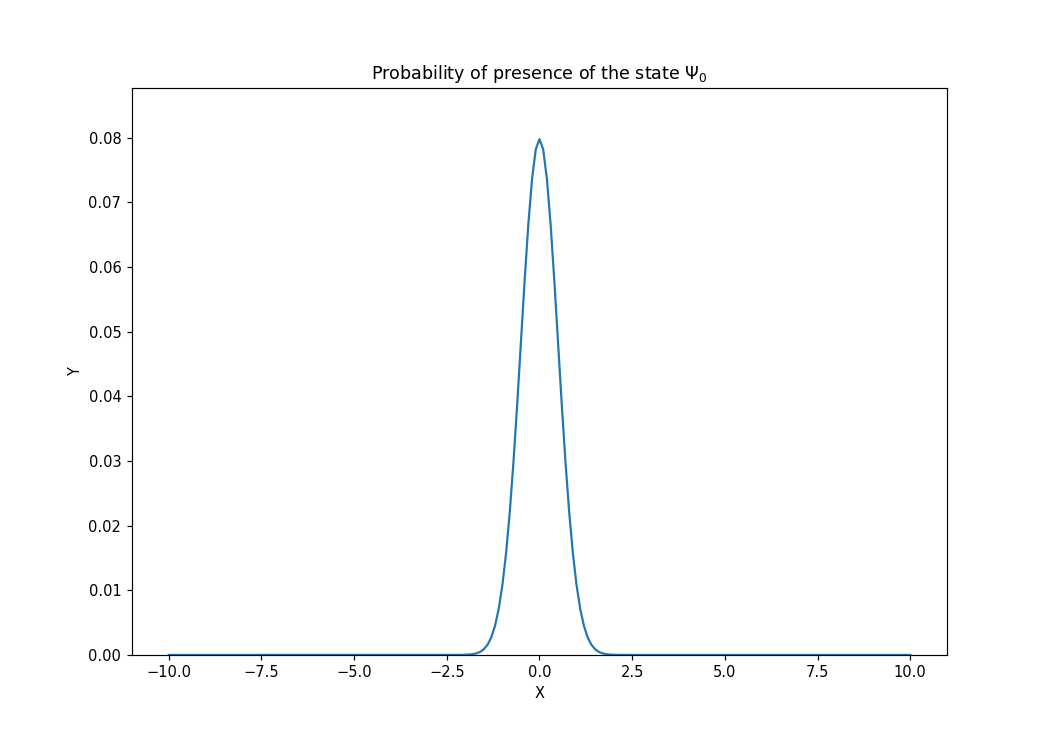

In [43]:
#GLobal params
param = {}

dim=1
param['dim'] = dim
simu_type =  'o2'

param['eps'] = .01
param['a'] = 1/2
param['b'] = 1/2
param['c'] = 0

dxs = [param['eps']**param['a']]
param['Nt'] = 200
param['max_width'] = 200

param['ax1'] = 2
param['ax2'] = 2

param['theta_0_x'] = -np.pi
param['delta_x'] = np.pi/2
param['zeta_x'] = -3*np.pi/2
param['phi_x'] = np.pi/2

param['theta_0_y'] = -2*np.pi
param['delta_y'] = 0
param['zeta_y'] = -np.pi/2
param['phi_y'] = np.pi/2


param['tau'] = 1
param['order'] = 'M_B_Sx_A_Cy_Sx_Cx_T_Sx_R_Cy_Sx_Cx'
param['init'] = init_gaussian_nD((100,), dxs , var_mat = None, mu_vect=None, spin=np.array([1, 1]))

param['m'] = 0
param['theta_1'] = .1
param['alpha_1'] = 3

stamp = mk_stamp(dim)
param['stamp'] = stamp


if dim == 1 and simu_type == 'twist' :
    update_function = update_param_1D_twist
    print("Kind of simulation : 1D and with a twist !")
elif dim == 1 and simu_type == 'norm' :
    update_function = update_param_1D
    print("Kind of simulation : normal 1D !")
elif dim == 1 and simu_type == 'o2' :
    update_function = update_param_1D_order2
    print("Kind of simulation : free two step with twist !")
else:
    print("Kind of simu not recognized, the parameter will not be changed !")
    update_function = lambda x:x
    
print("\n\n\n")

param = update_function(param)
_=_analyze_order(param, talk=True)

plot_state(param['init'], param['dxs'], frame = None, z_max = None, suff_name=r' $\Psi_0$')

# Simulation

In [44]:
#Simu
final, param = simu(param, 
                   bool_save = True, force = True,
                   talk = True, freq_mess = .2)

The Unitary consists in the following process :
  ---> Coin with angles delta_x; theta_x; phi_x; zeta_x
  ---> Shift in direction  x
  ---> Coin with angles delta_y; theta_y; phi_y; zeta_y
  ---> Operator defined by matrix stored in parameters as  R
  ---> Shift in direction  x
  ---> Operator defined by matrix stored in parameters as  T
  ---> Coin with angles delta_x; theta_x; phi_x; zeta_x
  ---> Shift in direction  x
  ---> Coin with angles delta_y; theta_y; phi_y; zeta_y
  ---> Operator defined by matrix stored in parameters as  A
  ---> Shift in direction  x
  ---> Operator defined by matrix stored in parameters as  B
  ---> Operator defined by matrix stored in parameters as  M


Starting at  2023-05-07 17:05:45.068890

Progress : 20.0 %
Current size (in space units) : 20.1
At : 2023-05-07 17:05:45.555022
Refined ending : 2023-05-07 17:05:47.499552

Progress : 40.0 %
Current size (in space units) : 29.1
At : 2023-05-07 17:05:46.027160
Refined ending : 2023-05-07 17:05:47.464565



<IPython.core.display.Javascript object>


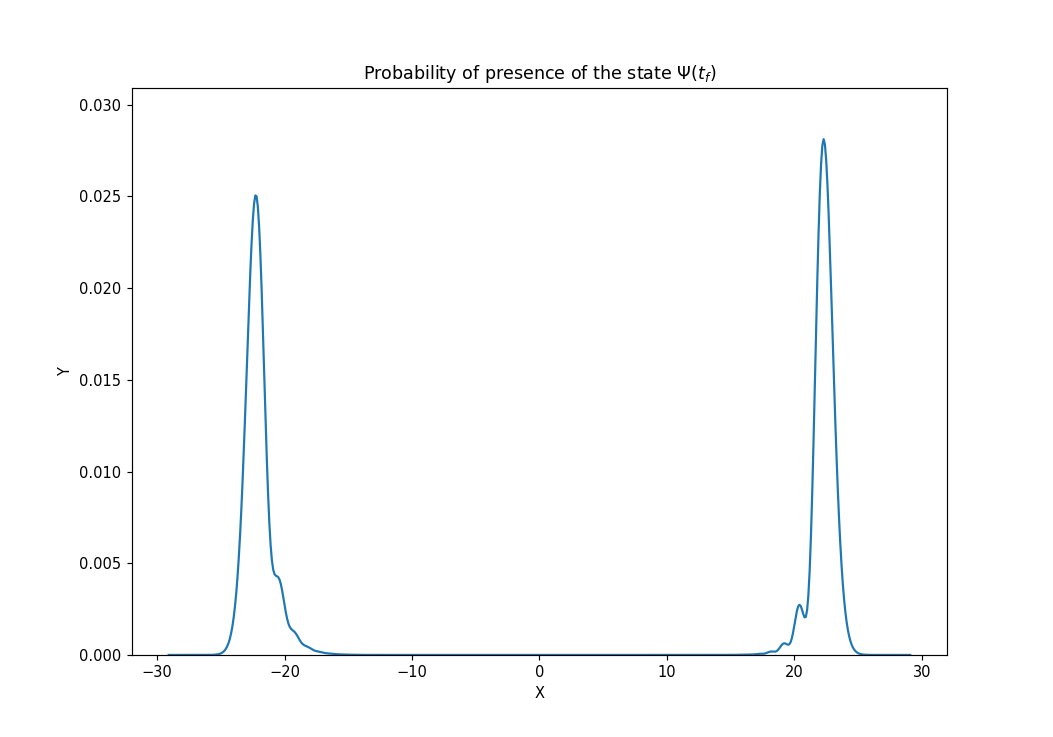

In [45]:
plot_state(final, param['dxs'], frame = None, z_max = None, suff_name=r' $\Psi(t_f)$')

# Post processing

re-create spec

Beware, we only take the real part of the eigenvalues
Max of imag is  1.4324815416971976e-13


<IPython.core.display.Javascript object>


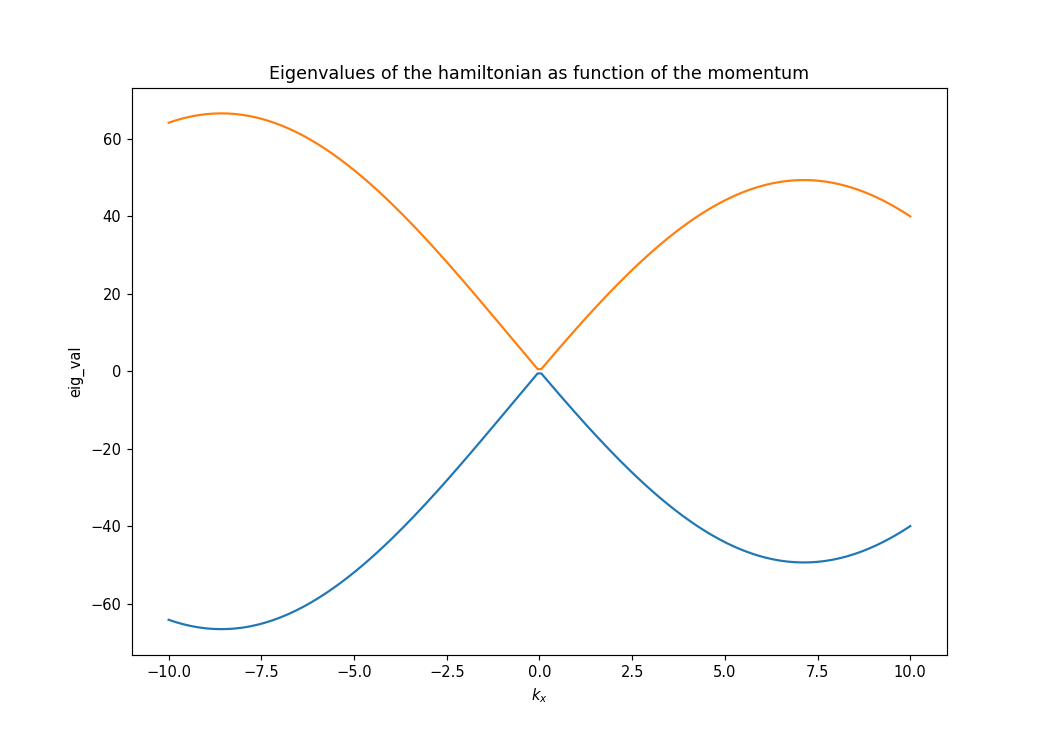

In [46]:
_, _ = mk_spec(stamp, frame = [np.linspace(-10, 10, 200)], 
               bool_plot = True, typ = 'real', force = False)

<IPython.core.display.Javascript object>


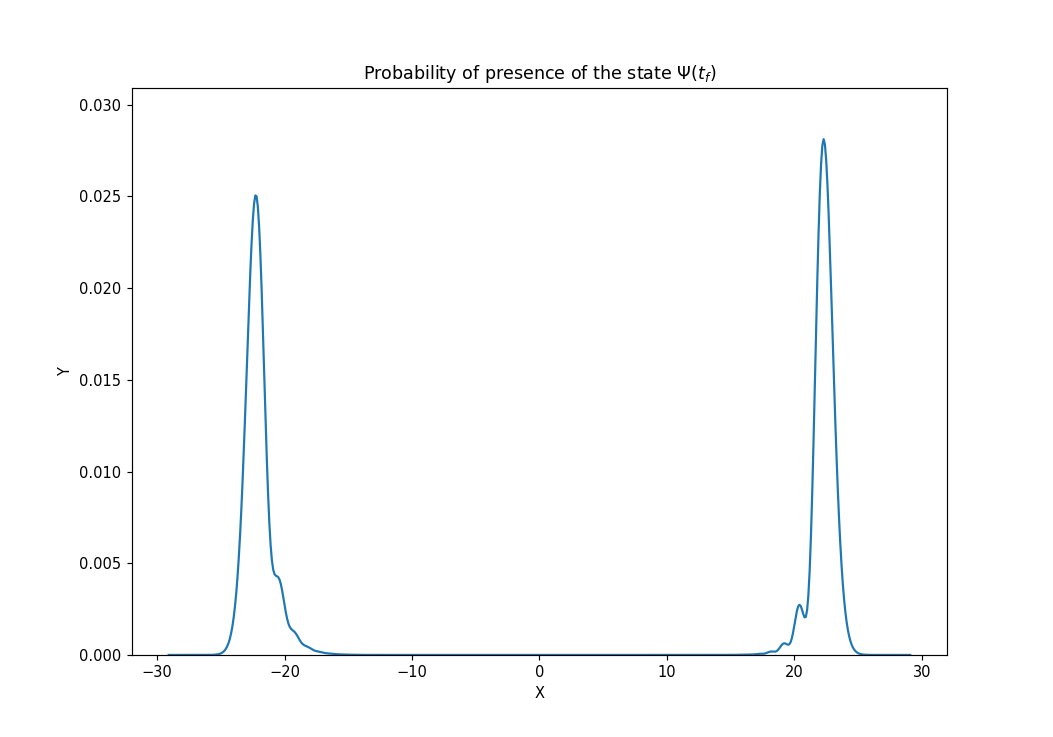

In [47]:
plot_state(final, dxs, frame = None, z_max = None, suff_name=r' $\Psi(t_f)$')

re-use spread


<IPython.core.display.Javascript object>


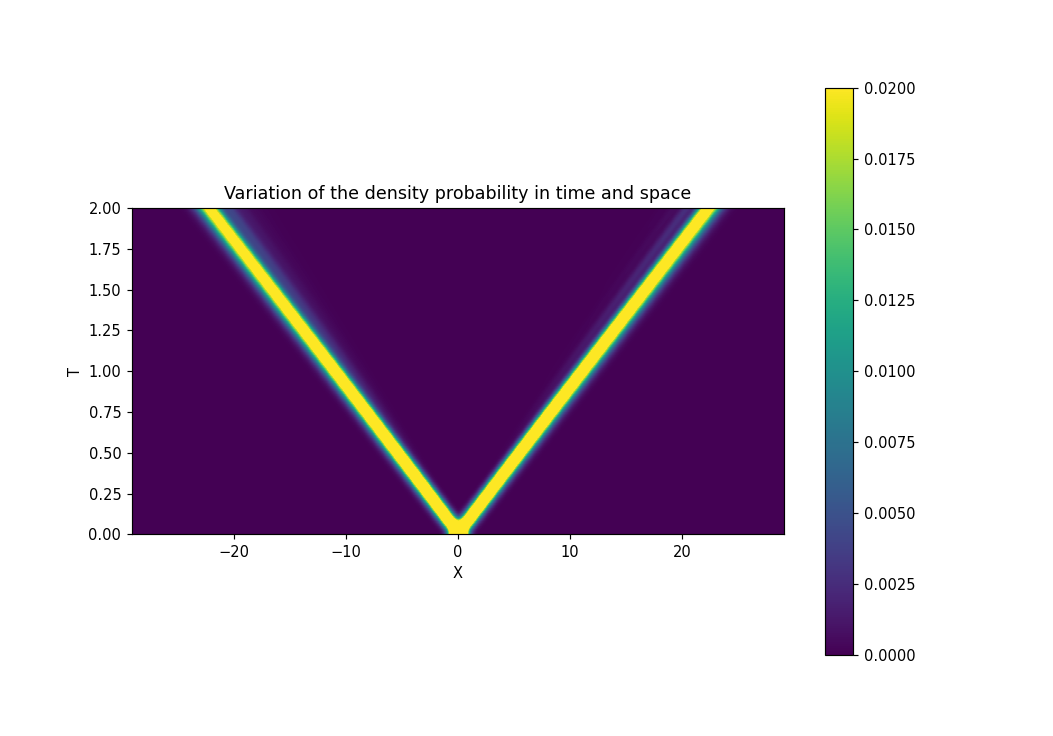

In [51]:
mat, X, Y = mk_spread_map(stamp, bool_plot = True, z_max = .02, force = False)

In [31]:
mk_gif(stamp, 
       fps=30, 
       keep=1, 
       z_max=None, frame = None, path='', force = False)

re create gif


re-use mu


<IPython.core.display.Javascript object>


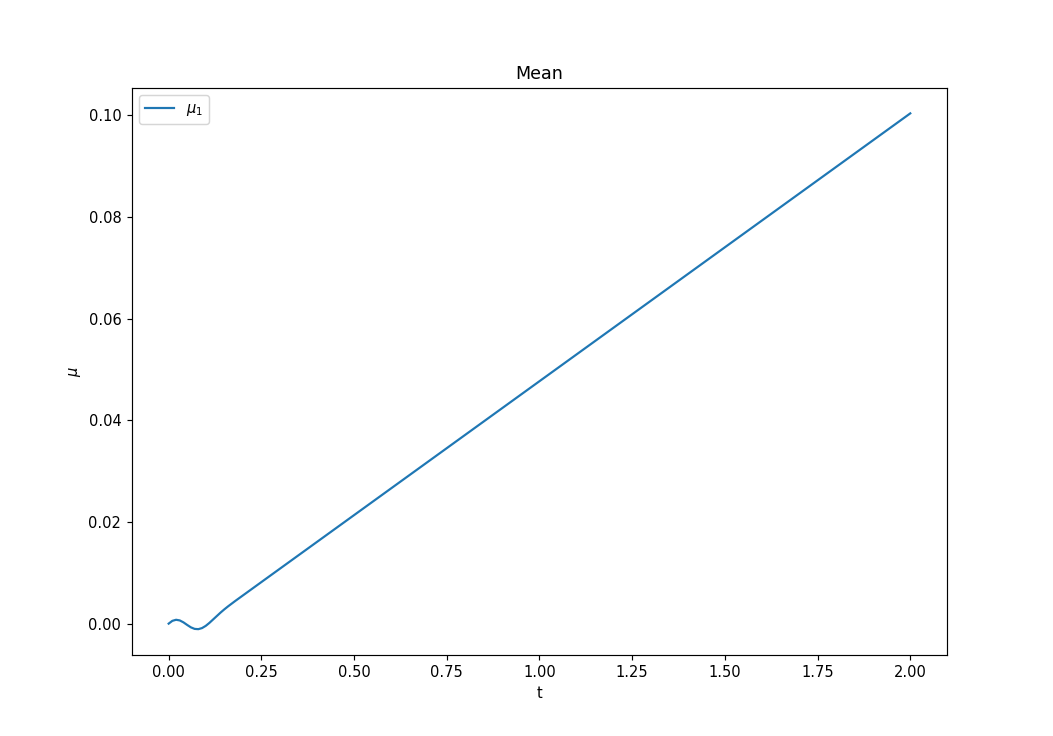

In [53]:
absc_mu, mu = repr_mean(stamp, bool_plot = True, force = False, z_min = None, z_max = None)

re-use sig
Initial variance is  :  0.24999999999999997


<IPython.core.display.Javascript object>


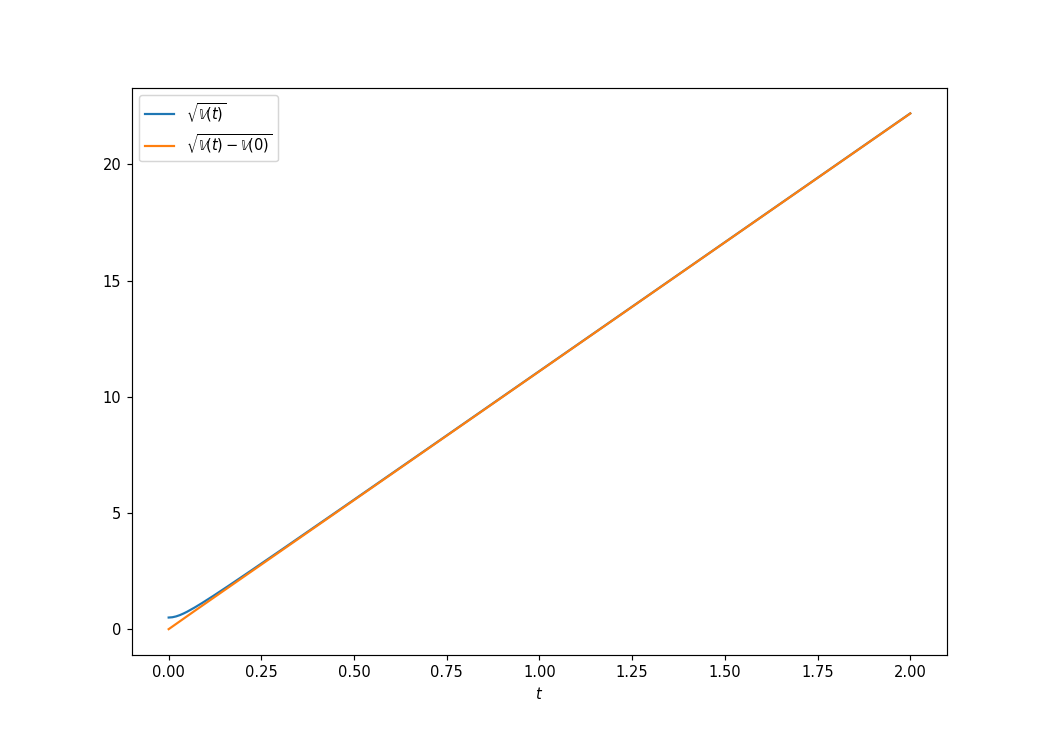

In [55]:
absc_var, var = repr_std(stamp, bool_plot = False, force = False, z_max = None, cov_min=None, cov_max=None)
var = var[:,0,0]

print("Initial variance is  : ", var[0])

plt.figure()
plt.plot(absc, np.sqrt(var), label = r'$\sqrt{\mathbb{V}(t)}$')
plt.plot(absc, np.sqrt(var - var[0]), label = r'$\sqrt{\mathbb{V}(t) - \mathbb{V}(0)}$')
plt.xlabel(r'$t$')
plt.legend()

re create sig


<IPython.core.display.Javascript object>


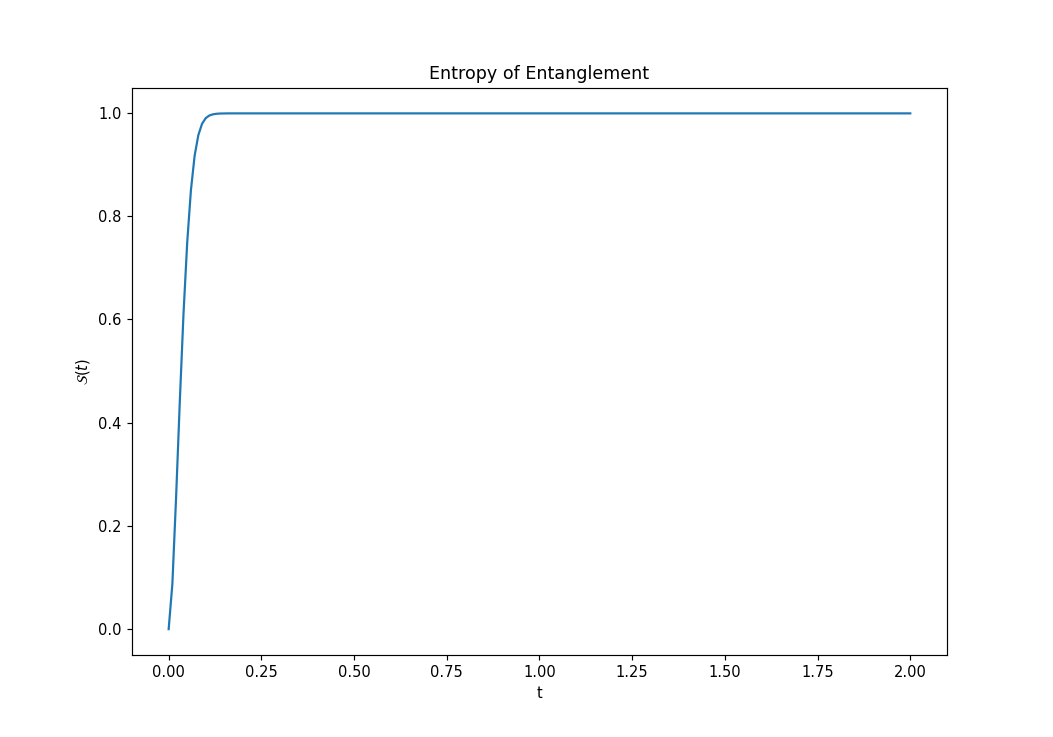

In [56]:
entrop_absc, entrop = repr_entrop(stamp, bool_plot = True, force = False, z_min = None, z_max = None)